# Notebook 25: Dimensionality Reduction with PCA

**Objective:** Apply PCA to reduce dimensionality of engineered LOB and Hawkes features.

**Steps:**
1. Load basic features (116) and Hawkes features (9)
2. Separate microstructure features from time-based features
3. Apply PCA to ~109 microstructure features
4. Analyze variance explained
5. Interpret principal components through loadings
6. (Optional) Test PCA stability across time windows
7. Save transformed features for downstream modeling

## 1. Setup and Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

from src.config import (
    RAW_DATA_DIR,
    INTERIM_DATA_DIR, 
    PROCESSED_DATA_DIR,
    FIGURES_DIR
)

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load Features

In [13]:
# Load basic features from notebook 10
SYMBOL = "BTCUSDT"
INPUT_FILE = PROCESSED_DATA_DIR / f"{SYMBOL}_basic_parquet.csv"
basic_features_path = INPUT_FILE # Adjust path as needed
basic_features = pd.read_parquet(basic_features_path)

print(f"Basic features shape: {basic_features.shape}")
print(f"Columns: {len(basic_features.columns)}")
print(f"Date range: {basic_features['timestamp'].min()} to {basic_features['timestamp'].max()}")

Basic features shape: (132214, 117)
Columns: 117
Date range: 2025-10-12 22:38:17+00:00 to 2025-10-14 15:43:45+00:00


In [14]:
# Load Hawkes features from notebook 20
hawkes_features_path = PROCESSED_DATA_DIR / 'hawkes_features.parquet'  # Adjust path as needed
hawkes_features = pd.read_parquet(hawkes_features_path)

print(f"Hawkes features shape: {hawkes_features.shape}")
print(f"Columns: {list(hawkes_features.columns)}")

Hawkes features shape: (202, 10)
Columns: ['timestamp', 'mu', 'alpha', 'beta', 'branching_ratio', 'window_start', 'window_end', 'n_events', 'regime', 'regime_duration']


In [15]:
# ========================================
# Merge features with time-based alignment
# ========================================

# Step 1: Convert Hawkes float timestamps to datetime
# Hawkes timestamps are seconds since the start of basic_features
reference_time = basic_features['timestamp'].min()
hawkes_features['timestamp'] = reference_time + pd.to_timedelta(hawkes_features['timestamp'], unit='s')

print("Timestamp conversion:")
print(f"  Reference time (basic start): {reference_time}")
print(f"  Hawkes timestamp range: {hawkes_features['timestamp'].min()} to {hawkes_features['timestamp'].max()}")
print(f"  Basic timestamp range: {basic_features['timestamp'].min()} to {basic_features['timestamp'].max()}")

# Step 2: Sort both dataframes by timestamp (required for merge_asof)
basic_features_sorted = basic_features.sort_values('timestamp').reset_index(drop=True)
hawkes_features_sorted = hawkes_features.sort_values('timestamp').reset_index(drop=True)

print(f"\nSorted dataframes:")
print(f"  Basic features: {len(basic_features_sorted)} rows")
print(f"  Hawkes features: {len(hawkes_features_sorted)} rows")

# Step 3: Merge using merge_asof (time-based join with forward-fill)
combined_features = pd.merge_asof(
    basic_features_sorted,
    hawkes_features_sorted,
    on='timestamp',
    direction='backward',  # Use most recent Hawkes estimate for each LOB snapshot
    tolerance=pd.Timedelta('10min')  # Optional: reject matches older than 10 minutes
)

print(f"\nCombined features shape: {combined_features.shape}")
print(f"Total columns: {len(combined_features.columns)}")

# Step 4: Check for missing values
missing_counts = combined_features.isnull().sum()
if missing_counts.sum() > 0:
    print("\nMissing values detected:")
    print(missing_counts[missing_counts > 0])
    
    # Identify Hawkes columns
    hawkes_cols = [col for col in hawkes_features.columns if col != 'timestamp']
    
    # Count missing values in Hawkes features
    hawkes_missing = combined_features[hawkes_cols].isnull().sum()
    if hawkes_missing.sum() > 0:
        print(f"\nMissing Hawkes features: {hawkes_missing.sum()} total")
        print("These are likely early timestamps before the first Hawkes estimate.")
        
        # Backward fill (fill NaNs with next valid value)
        print("\nApplying backward fill for early timestamps...")
        combined_features[hawkes_cols] = combined_features[hawkes_cols].fillna(method='bfill')
        
        # Check again
        remaining_missing = combined_features[hawkes_cols].isnull().sum()
        if remaining_missing.sum() > 0:
            print(f"\nStill missing after bfill: {remaining_missing.sum()}")
            # Forward fill as last resort
            combined_features[hawkes_cols] = combined_features[hawkes_cols].fillna(method='ffill')
            
        print(f"Final missing values: {combined_features.isnull().sum().sum()}")
else:
    print("\nNo missing values - perfect alignment!")

# Step 5: Verify the merge
print("\n" + "="*60)
print("MERGE VERIFICATION")
print("="*60)
print(f"Original basic features:     {len(basic_features)} rows")
print(f"Original Hawkes features:    {len(hawkes_features)} rows")
print(f"Combined features:           {len(combined_features)} rows")
print(f"Columns in combined:         {len(combined_features.columns)}")
print(f"  - Basic features columns:  {len(basic_features.columns)}")
print(f"  - Hawkes features columns: {len(hawkes_features.columns) - 1}")  # -1 for timestamp
print(f"  - Expected total:          {len(basic_features.columns) + len(hawkes_features.columns) - 1}")

# Show sample of merged data
print("\nSample of merged data (first 5 rows, showing timestamp + Hawkes columns):")
hawkes_display_cols = ['timestamp'] + [col for col in hawkes_features.columns if col != 'timestamp']
print(combined_features[hawkes_display_cols].head())

Timestamp conversion:
  Reference time (basic start): 2025-10-12 22:38:17+00:00
  Hawkes timestamp range: 2025-10-13 00:35:12.448000+00:00 to 2025-10-14 23:00:45.923000+00:00
  Basic timestamp range: 2025-10-12 22:38:17+00:00 to 2025-10-14 15:43:45+00:00

Sorted dataframes:
  Basic features: 132214 rows
  Hawkes features: 202 rows

Combined features shape: (132214, 126)
Total columns: 126

Missing values detected:
log_return_lag_1                              1
log_return_lag_2                              2
log_return_lag_3                              3
log_return_lag_5                              5
log_return_lag_10                            10
log_return_lag_20                            20
log_return_lag_30                            30
log_return_lag_60                            60
rolling_vol_20                               20
rolling_vol_10                               10
rolling_vol_60                               60
rolling_vol_100                             100
realiz

In [17]:
# Check for missing values
missing_counts = combined_features.isnull().sum()
if missing_counts.sum() > 0:
    print("\nMissing values detected:")
    print(missing_counts[missing_counts > 0])
    
    # Separate basic features missing values from Hawkes features
    basic_cols = [col for col in basic_features.columns if col != 'timestamp']
    hawkes_cols = [col for col in hawkes_features.columns if col != 'timestamp']
    
    basic_missing = combined_features[basic_cols].isnull().sum()
    hawkes_missing = combined_features[hawkes_cols].isnull().sum()
    
    print(f"\nMissing breakdown:")
    print(f"  Basic features missing: {basic_missing.sum()}")
    print(f"  Hawkes features missing: {hawkes_missing.sum()}")
    
    # ==========================================
    # Fix 1: Handle Hawkes features missing values
    # ==========================================
    if hawkes_missing.sum() > 0:
        print(f"\nFixing {hawkes_missing.sum()} missing Hawkes features...")
        print("Strategy: Backward fill (use next valid value for early timestamps)")
        
        combined_features[hawkes_cols] = combined_features[hawkes_cols].fillna(method='bfill')
        
        # Check if any still missing
        hawkes_still_missing = combined_features[hawkes_cols].isnull().sum().sum()
        if hawkes_still_missing > 0:
            print(f"  Still missing after bfill: {hawkes_still_missing}")
            print("  Applying forward fill as backup...")
            combined_features[hawkes_cols] = combined_features[hawkes_cols].fillna(method='ffill')
        
        hawkes_final_missing = combined_features[hawkes_cols].isnull().sum().sum()
        print(f"  Hawkes features after filling: {hawkes_final_missing} missing")
    
    # ==========================================
    # Fix 2: Handle basic features missing values (lagged features)
    # ==========================================
    if basic_missing.sum() > 0:
        print(f"\nFixing {basic_missing.sum()} missing basic features...")
        
        # Lagged features: forward fill (most appropriate for time series)
        lagged_cols = [col for col in basic_cols if 'lag' in col or 'rolling' in col or 'time_since' in col]
        if lagged_cols:
            print(f"  Forward filling {len(lagged_cols)} lagged/rolling features...")
            combined_features[lagged_cols] = combined_features[lagged_cols].fillna(method='ffill')
        
        # Any other missing: fill with 0 or median
        remaining_missing_cols = [col for col in basic_cols if combined_features[col].isnull().sum() > 0]
        if remaining_missing_cols:
            print(f"  Filling {len(remaining_missing_cols)} remaining columns with 0...")
            combined_features[remaining_missing_cols] = combined_features[remaining_missing_cols].fillna(0)
    
    # Final check
    final_missing = combined_features.isnull().sum().sum()
    print(f"\n✓ Final missing values: {final_missing}")
    
    if final_missing > 0:
        print("\nColumns still with missing values:")
        still_missing = combined_features.isnull().sum()
        print(still_missing[still_missing > 0])
else:
    print("\n✓ No missing values - perfect!")

# ==========================================
# Additional verification
# ==========================================
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for infinite values
inf_counts = np.isinf(combined_features.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(f"⚠ Infinite values detected: {inf_counts.sum()}")
    print(inf_counts[inf_counts > 0])
else:
    print("✓ No infinite values")

# Check Hawkes features statistics
print("\nHawkes Features Summary:")
for col in hawkes_cols:
    non_null_count = combined_features[col].notna().sum()
    unique_count = combined_features[col].nunique()
    print(f"  {col}: {non_null_count} non-null, {unique_count} unique values")

print("\n" + "="*60)
print("MERGE VERIFICATION")
print("="*60)
print(f"Original basic features:     {len(basic_features)} rows")
print(f"Original Hawkes features:    {len(hawkes_features)} rows")
print(f"Combined features:           {len(combined_features)} rows")
print(f"Columns in combined:         {len(combined_features.columns)}")
print(f"Missing values:              {combined_features.isnull().sum().sum()}")
print(f"Infinite values:             {np.isinf(combined_features.select_dtypes(include=[np.number])).sum().sum()}")

# Show sample of merged data
print("\nSample of merged data (first 5 rows):")
display_cols = ['timestamp', 'mid_price', 'spread_abs', 'imbalance_top'] + hawkes_cols[:3]
print(combined_features[display_cols].head())

print("\nSample of merged data (last 5 rows):")
print(combined_features[display_cols].tail())


✓ No missing values - perfect!

DATA QUALITY CHECK
✓ No infinite values

Hawkes Features Summary:
  mu: 132214 non-null, 168 unique values
  alpha: 132214 non-null, 168 unique values
  beta: 132214 non-null, 168 unique values
  branching_ratio: 132214 non-null, 168 unique values
  window_start: 132214 non-null, 168 unique values
  window_end: 132214 non-null, 168 unique values
  n_events: 132214 non-null, 1 unique values
  regime: 132214 non-null, 2 unique values
  regime_duration: 132214 non-null, 84 unique values

MERGE VERIFICATION
Original basic features:     132214 rows
Original Hawkes features:    202 rows
Combined features:           132214 rows
Columns in combined:         126
Missing values:              0
Infinite values:             0

Sample of merged data (first 5 rows):
                  timestamp   mid_price  spread_abs  imbalance_top        mu  \
0 2025-10-12 22:38:17+00:00  115284.395      496.31       0.454689  0.022949   
1 2025-10-12 22:38:18+00:00  115284.395     

## 3. Separate Feature Groups

In [18]:
# Define time-based features to EXCLUDE from PCA
time_features = [
    'timestamp',
    'hour',
    'minute',
    'seconds_since_midnight',
    'hour_sin',
    'hour_cos',
    'minute_sin',
    'minute_cos',
    'minutes_since_open',
    'minutes_until_close',
    'session_progress',
    'is_market_hours',
    'session_period'
]

# Get all feature columns (excluding time features)
all_columns = combined_features.columns.tolist()
microstructure_features = [col for col in all_columns if col not in time_features]

print(f"Total columns: {len(all_columns)}")
print(f"Time features (excluded from PCA): {len(time_features)}")
print(f"Microstructure features (for PCA): {len(microstructure_features)}")

# Display feature breakdown
print("\nTime features:")
print(time_features)
print("\nFirst 10 microstructure features:")
print(microstructure_features[:10])

Total columns: 126
Time features (excluded from PCA): 13
Microstructure features (for PCA): 113

Time features:
['timestamp', 'hour', 'minute', 'seconds_since_midnight', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'minutes_since_open', 'minutes_until_close', 'session_progress', 'is_market_hours', 'session_period']

First 10 microstructure features:
['mid_price', 'weighted_mid', 'spread_abs', 'spread_bps', 'average_spread', 'spread_level_1', 'spread_level_2', 'spread_level_3', 'spread_level_4', 'spread_level_5']


## 4. Data Preparation for PCA

In [19]:
# Extract microstructure features for PCA
X = combined_features[microstructure_features].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Check for infinite values
inf_counts = np.isinf(X).sum()
if inf_counts.sum() > 0:
    print("\nInfinite values detected:")
    print(inf_counts[inf_counts > 0])
    # Replace inf with NaN, then handle
    X = X.replace([np.inf, -np.inf], np.nan)

Feature matrix shape: (132214, 113)
Features: 113
Samples: 132214


In [20]:
# Handle missing values (if any)
missing_before = X.isnull().sum().sum()
if missing_before > 0:
    print(f"Missing values before handling: {missing_before}")
    
    # Option 1: Forward fill then backward fill
    X = X.fillna(method='ffill').fillna(method='bfill')
    
    # Option 2: Fill with column mean (alternative)
    # X = X.fillna(X.mean())
    
    missing_after = X.isnull().sum().sum()
    print(f"Missing values after handling: {missing_after}")
else:
    print("No missing values to handle.")

No missing values to handle.


In [21]:
# Split into train/test (time-series split - NO shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train date range: {combined_features.iloc[:split_idx]['timestamp'].min()} to {combined_features.iloc[:split_idx]['timestamp'].max()}")
print(f"Test date range: {combined_features.iloc[split_idx:]['timestamp'].min()} to {combined_features.iloc[split_idx:]['timestamp'].max()}")

Train set: (105771, 113)
Test set: (26443, 113)
Train date range: 2025-10-12 22:38:17+00:00 to 2025-10-14 07:23:49+00:00
Test date range: 2025-10-14 07:23:50+00:00 to 2025-10-14 15:43:45+00:00


## 5. Feature Standardization

**Critical:** PCA is sensitive to feature scales. We must standardize (mean=0, std=1).

In [22]:
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")

# Verify standardization
print(f"\nTrain mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"Train std (should be ~1): {X_train_scaled.std():.6f}")
print(f"Test mean: {X_test_scaled.mean():.6f}")
print(f"Test std: {X_test_scaled.std():.6f}")

Train scaled shape: (105771, 113)
Test scaled shape: (26443, 113)

Train mean (should be ~0): -0.000000
Train std (should be ~1): 0.995565
Test mean: -0.265024
Test std: 1.552973


## 6. Apply PCA

In [23]:
# Fit PCA on training data
# Keep all components initially to analyze variance explained
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train_scaled)

print(f"Total components: {pca.n_components_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Total components: 113
Total variance explained: 1.0000


## 7. Variance Explained Analysis

In [24]:
# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
print("Components needed for variance explained:")
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"  {threshold*100:.0f}%: {n_components} components")

Components needed for variance explained:
  80%: 18 components
  85%: 23 components
  90%: 29 components
  95%: 37 components
  99%: 54 components


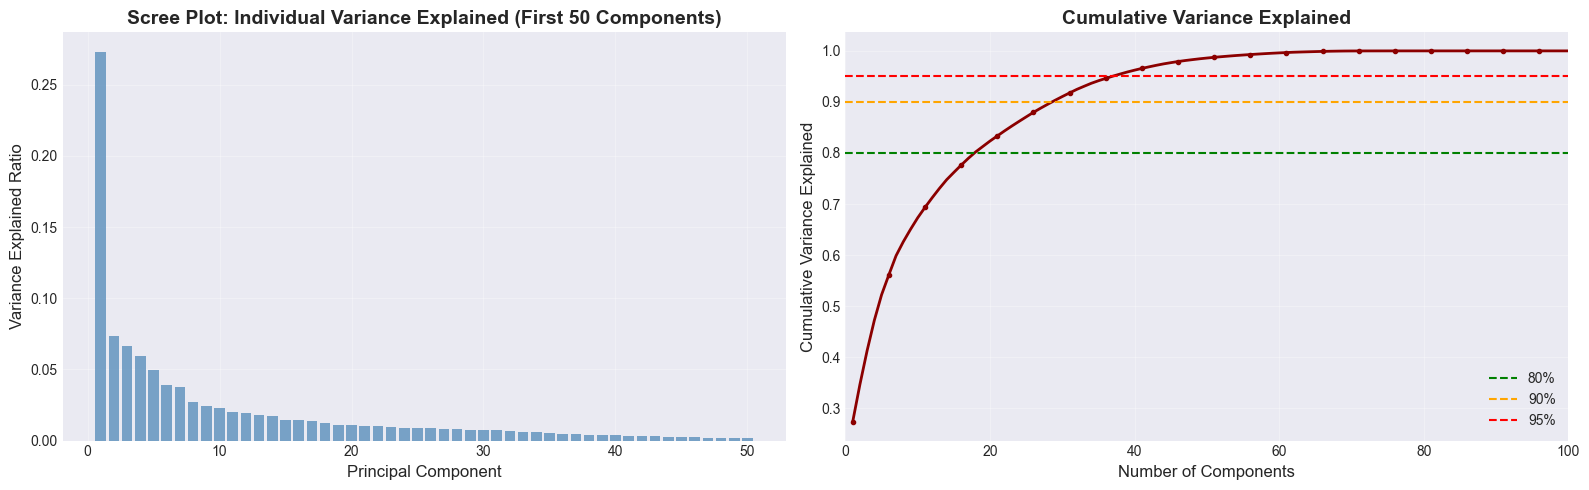

In [25]:
# Scree plot - variance explained by each component
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual variance
axes[0].bar(range(1, min(51, len(pca.explained_variance_ratio_)+1)), 
            pca.explained_variance_ratio_[:50], 
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Individual Variance Explained (First 50 Components)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
             linewidth=2, color='darkred', marker='o', markersize=3, markevery=5)
axes[1].axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, label='80%')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90%')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=1.5, label='95%')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, min(100, len(cumulative_variance)))

plt.tight_layout()
plt.savefig('../reports/figures/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Show first 20 components variance contribution
variance_df = pd.DataFrame({
    'Component': range(1, 21),
    'Variance Explained': pca.explained_variance_ratio_[:20],
    'Cumulative Variance': cumulative_variance[:20]
})

print("\nFirst 20 Principal Components:")
print(variance_df.to_string(index=False))


First 20 Principal Components:
 Component  Variance Explained  Cumulative Variance
         1            0.273187             0.273187
         2            0.073182             0.346370
         3            0.066601             0.412971
         4            0.059423             0.472394
         5            0.049894             0.522288
         6            0.038807             0.561095
         7            0.037615             0.598710
         8            0.027360             0.626071
         9            0.024327             0.650397
        10            0.022779             0.673176
        11            0.020159             0.693336
        12            0.019064             0.712400
        13            0.018215             0.730615
        14            0.017045             0.747660
        15            0.014387             0.762047
        16            0.014088             0.776135
        17            0.013414             0.789548
        18            0.012433  

## 8. Select Optimal Number of Components

**Decision:** Choose number of components based on:
- Variance explained (typically 85-95%)
- Elbow in scree plot
- Downstream modeling needs

In [27]:
# Set target variance (adjust based on your analysis)
target_variance = 0.90
n_components_selected = np.argmax(cumulative_variance >= target_variance) + 1

print(f"Selected number of components: {n_components_selected}")
print(f"Variance explained: {cumulative_variance[n_components_selected-1]:.4f}")
print(f"Dimensionality reduction: {X_train.shape[1]} → {n_components_selected}")
print(f"Compression ratio: {n_components_selected / X_train.shape[1]:.2%}")

Selected number of components: 29
Variance explained: 0.9032
Dimensionality reduction: 113 → 29
Compression ratio: 25.66%


In [28]:
# Refit PCA with selected number of components
pca_final = PCA(n_components=n_components_selected, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

print(f"Train PCA shape: {X_train_pca.shape}")
print(f"Test PCA shape: {X_test_pca.shape}")

Train PCA shape: (105771, 29)
Test PCA shape: (26443, 29)


## 9. Principal Component Interpretation

**Goal:** Understand what each component represents by examining feature loadings.

In [29]:
# Get component loadings (eigenvectors)
loadings = pca_final.components_.T  # Shape: (n_features, n_components)

# Create loadings dataframe
loadings_df = pd.DataFrame(
    loadings,
    columns=[f'PC{i+1}' for i in range(n_components_selected)],
    index=microstructure_features
)

print(f"Loadings shape: {loadings_df.shape}")
print("\nFirst 10 features loadings on first 5 PCs:")
print(loadings_df.iloc[:10, :5])

Loadings shape: (113, 29)

First 10 features loadings on first 5 PCs:
                     PC1       PC2       PC3       PC4       PC5
mid_price       0.117923 -0.050398 -0.030059 -0.054181 -0.204774
weighted_mid    0.132645 -0.050833 -0.019329 -0.048808 -0.157328
spread_abs      0.032845  0.297447  0.005586  0.081019 -0.058887
spread_bps      0.029436  0.298927  0.006566  0.082822 -0.053396
average_spread -0.002434  0.075253 -0.010456  0.025481 -0.031865
spread_level_1  0.032845  0.297447  0.005586  0.081019 -0.058887
spread_level_2  0.031295  0.300973 -0.004636  0.092188 -0.054280
spread_level_3  0.027637  0.301655 -0.020616  0.109875 -0.031018
spread_level_4  0.026137  0.294492 -0.041998  0.121548 -0.007524
spread_level_5  0.022555  0.283186 -0.060071  0.128717  0.005222


In [30]:
# Identify top features for each principal component
def get_top_features(loadings_df, pc_name, n_top=10):
    """Get top N features with highest absolute loadings for a PC."""
    abs_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
    top_features = abs_loadings.head(n_top)
    
    # Get actual loading values (with sign)
    top_features_with_sign = loadings_df.loc[top_features.index, pc_name]
    
    return pd.DataFrame({
        'Feature': top_features.index,
        'Loading': top_features_with_sign.values,
        'Abs_Loading': top_features.values
    })

# Analyze first 3 principal components
for i in range(min(3, n_components_selected)):
    pc_name = f'PC{i+1}'
    print(f"\n{'='*80}")
    print(f"{pc_name} - Variance Explained: {pca_final.explained_variance_ratio_[i]:.4f}")
    print(f"{'='*80}")
    top_features = get_top_features(loadings_df, pc_name, n_top=10)
    print(top_features.to_string(index=False))


PC1 - Variance Explained: 0.2732
                               Feature  Loading  Abs_Loading
                    cumulative_vol_imb 0.173693     0.173693
                    depth_imbalance_10 0.173362     0.173362
                     imbalance_10level 0.173274     0.173274
               cumulative_vol_imb_norm 0.173274     0.173274
cumulative_volume_imbalance_rolling_10 0.173255     0.173255
         cumulative_vol_imb_rolling_20 0.173131     0.173131
cumulative_volume_imbalance_rolling_30 0.173021     0.173021
cumulative_volume_imbalance_rolling_60 0.172696     0.172696
                     avg_bid_volume_10 0.171075     0.171075
                          bid_depth_10 0.171075     0.171075

PC2 - Variance Explained: 0.0732
       Feature  Loading  Abs_Loading
spread_level_3 0.301655     0.301655
spread_level_2 0.300973     0.300973
    spread_bps 0.298927     0.298927
spread_level_1 0.297447     0.297447
    spread_abs 0.297447     0.297447
spread_level_4 0.294492     0.294492
sp

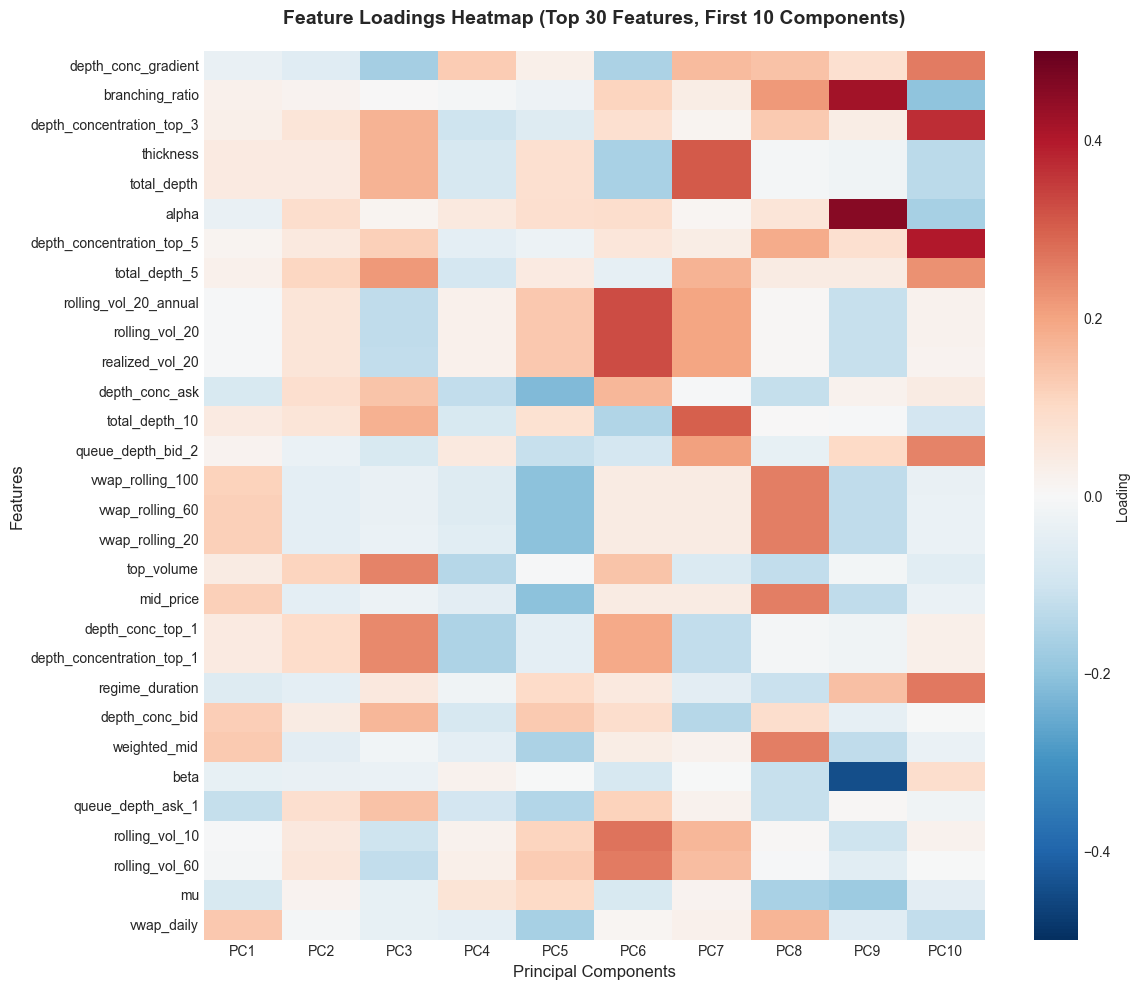

In [31]:
# Visualize loadings heatmap for first 10 components
n_pcs_to_plot = min(10, n_components_selected)
n_features_to_plot = 30  # Top features by variance across components

# Select top features with highest variance across components
feature_variance = loadings_df.iloc[:, :n_pcs_to_plot].abs().sum(axis=1).sort_values(ascending=False)
top_features_idx = feature_variance.head(n_features_to_plot).index

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    loadings_df.loc[top_features_idx, [f'PC{i+1}' for i in range(n_pcs_to_plot)]],
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Loading'},
    yticklabels=True,
    xticklabels=True,
    vmin=-0.5,
    vmax=0.5
)
plt.title(f'Feature Loadings Heatmap (Top {n_features_to_plot} Features, First {n_pcs_to_plot} Components)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/figures/pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Visualize Principal Components

**Goal:** Visualize data in principal component space.

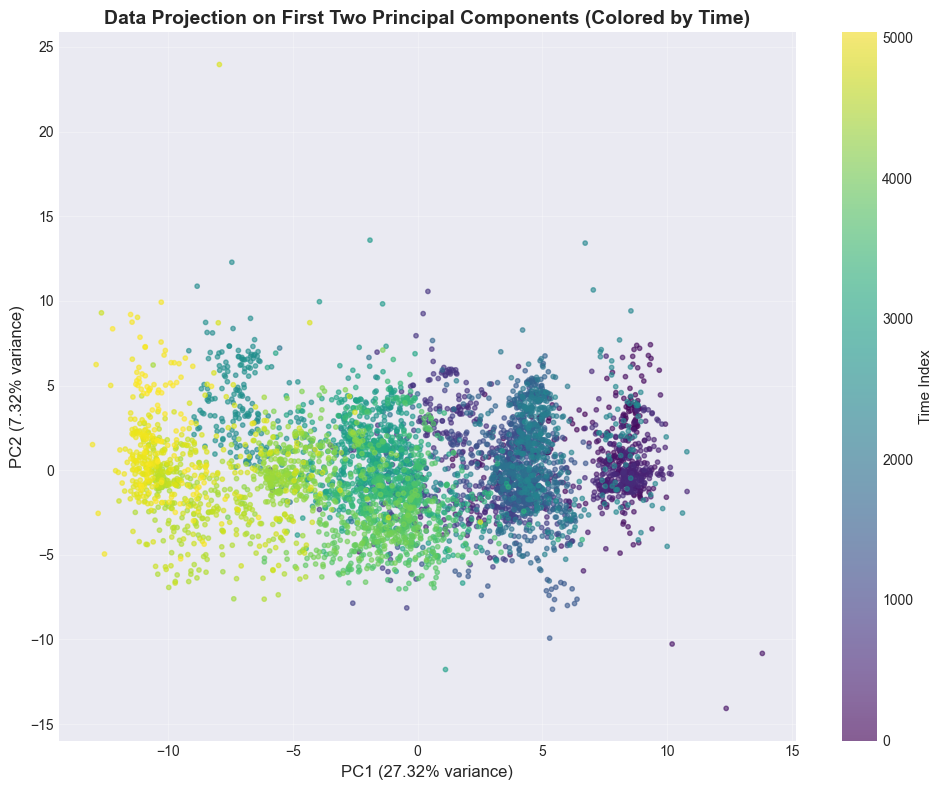

In [32]:
# 2D scatter plot of first two principal components
fig, ax = plt.subplots(figsize=(10, 8))

# Sample data for plotting (plot every Nth point to avoid clutter)
sample_rate = max(1, len(X_train_pca) // 5000)
sample_idx = np.arange(0, len(X_train_pca), sample_rate)

scatter = ax.scatter(
    X_train_pca[sample_idx, 0], 
    X_train_pca[sample_idx, 1],
    c=range(len(sample_idx)),  # Color by time
    cmap='viridis',
    alpha=0.6,
    s=10
)

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('Data Projection on First Two Principal Components (Colored by Time)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time Index', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/figures/pca_2d_projection.png', dpi=300, bbox_inches='tight')
plt.show()

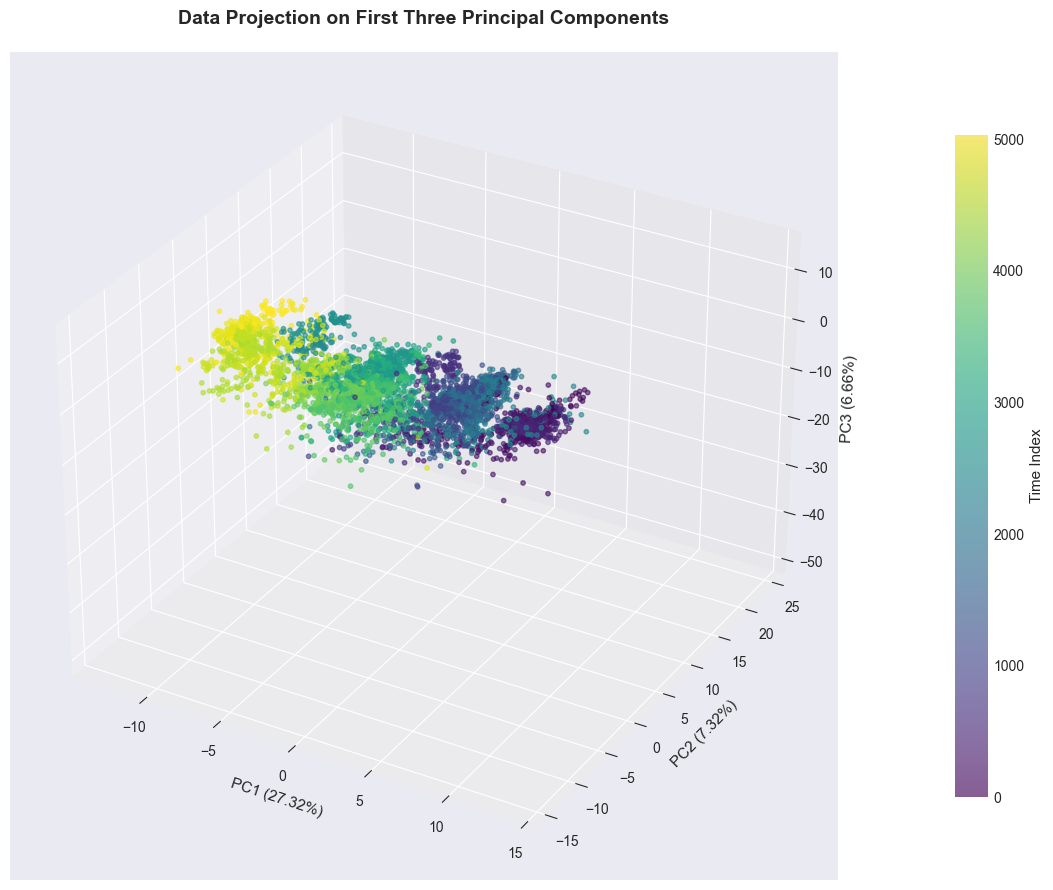

In [33]:
# 3D scatter plot of first three principal components
if n_components_selected >= 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        X_train_pca[sample_idx, 0],
        X_train_pca[sample_idx, 1],
        X_train_pca[sample_idx, 2],
        c=range(len(sample_idx)),
        cmap='viridis',
        alpha=0.6,
        s=10
    )
    
    ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.2%})', fontsize=11)
    ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.2%})', fontsize=11)
    ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]:.2%})', fontsize=11)
    ax.set_title('Data Projection on First Three Principal Components', 
                 fontsize=14, fontweight='bold', pad=20)
    
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
    cbar.set_label('Time Index', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/pca_3d_projection.png', dpi=300, bbox_inches='tight')
    plt.show()

## 11. PCA Stability Analysis 

**Goal:** Test if PCA structure is stable across different time windows.

In [34]:
# Split data into multiple time windows
n_windows = 5
window_size = len(X_train_scaled) // n_windows

print(f"Analyzing PCA stability across {n_windows} time windows")
print(f"Window size: {window_size} samples\n")

# Store PCA results for each window
window_results = []

for i in range(n_windows):
    start_idx = i * window_size
    end_idx = (i + 1) * window_size if i < n_windows - 1 else len(X_train_scaled)
    
    # Extract window
    X_window = X_train_scaled[start_idx:end_idx]
    
    # Fit PCA
    pca_window = PCA(n_components=n_components_selected, random_state=42)
    pca_window.fit(X_window)
    
    window_results.append({
        'window': i + 1,
        'pca': pca_window,
        'variance_explained': pca_window.explained_variance_ratio_,
        'start_idx': start_idx,
        'end_idx': end_idx
    })
    
    print(f"Window {i+1}: samples {start_idx}-{end_idx}, "
          f"variance explained: {pca_window.explained_variance_ratio_.sum():.4f}")

Analyzing PCA stability across 5 time windows
Window size: 21154 samples

Window 1: samples 0-21154, variance explained: 0.9347
Window 2: samples 21154-42308, variance explained: 0.9351
Window 3: samples 42308-63462, variance explained: 0.9294
Window 4: samples 63462-84616, variance explained: 0.9165
Window 5: samples 84616-105771, variance explained: 0.9300


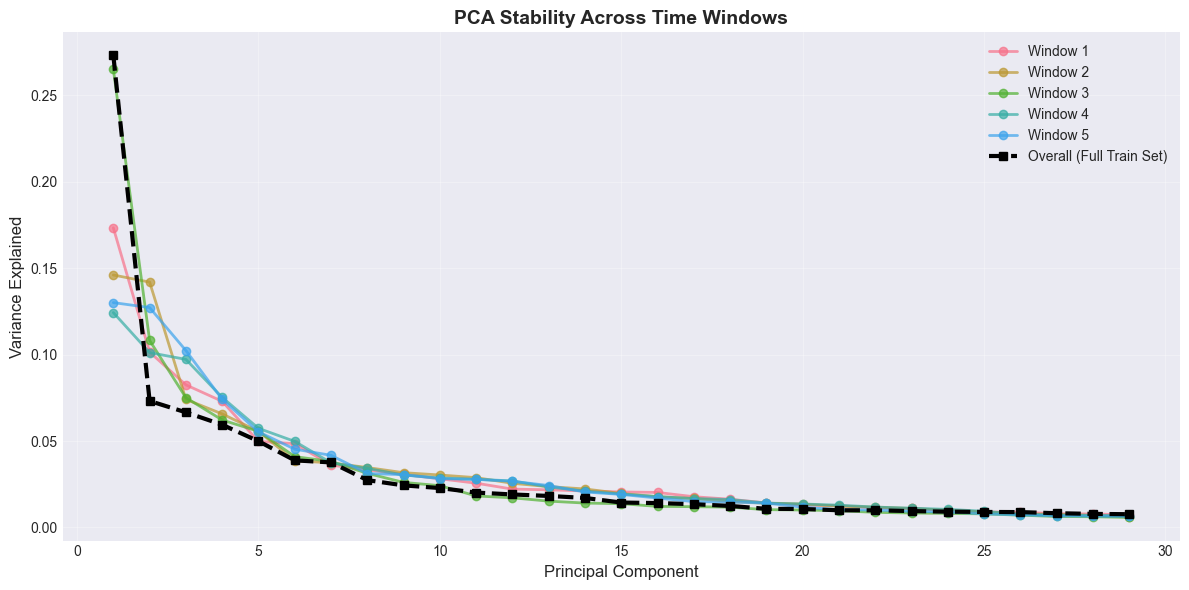

In [35]:
# Compare variance explained across windows
fig, ax = plt.subplots(figsize=(12, 6))

for result in window_results:
    ax.plot(
        range(1, n_components_selected + 1),
        result['variance_explained'],
        marker='o',
        label=f"Window {result['window']}",
        alpha=0.7,
        linewidth=2
    )

# Add overall PCA line
ax.plot(
    range(1, n_components_selected + 1),
    pca_final.explained_variance_ratio_,
    marker='s',
    label='Overall (Full Train Set)',
    linewidth=3,
    color='black',
    linestyle='--'
)

ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Variance Explained', fontsize=12)
ax.set_title('PCA Stability Across Time Windows', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/pca_stability_variance.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Calculate stability metric: average correlation of loadings across windows
def calculate_loading_similarity(pca1, pca2, n_components=5):
    """Calculate average absolute correlation between corresponding PCs."""
    correlations = []
    for i in range(min(n_components, pca1.n_components_, pca2.n_components_)):
        # Correlation between loadings of i-th component
        corr = np.corrcoef(pca1.components_[i], pca2.components_[i])[0, 1]
        correlations.append(abs(corr))  # Absolute value (sign can flip)
    return np.mean(correlations)

# Compare each window to the overall PCA
print("\nLoading Similarity (correlation with overall PCA):")
print("Higher values indicate more stable component structure\n")

similarity_scores = []
for result in window_results:
    similarity = calculate_loading_similarity(result['pca'], pca_final, n_components=5)
    similarity_scores.append(similarity)
    print(f"Window {result['window']}: {similarity:.4f}")

print(f"\nAverage similarity: {np.mean(similarity_scores):.4f}")
print(f"Std deviation: {np.std(similarity_scores):.4f}")

if np.mean(similarity_scores) > 0.80:
    print("\n✓ PCA structure is STABLE across time windows.")
elif np.mean(similarity_scores) > 0.60:
    print("\n⚠ PCA structure has MODERATE stability. Consider periodic recalibration.")
else:
    print("\n✗ PCA structure is UNSTABLE. Frequent recalibration needed.")


Loading Similarity (correlation with overall PCA):
Higher values indicate more stable component structure

Window 1: 0.5248
Window 2: 0.4710
Window 3: 0.4794
Window 4: 0.1702
Window 5: 0.2186

Average similarity: 0.3728
Std deviation: 0.1476

✗ PCA structure is UNSTABLE. Frequent recalibration needed.


## 12. Save PCA-Transformed Features

In [37]:
# Create DataFrames with PCA components
pca_columns = [f'PC{i+1}' for i in range(n_components_selected)]

# Train set
train_pca_df = pd.DataFrame(
    X_train_pca,
    columns=pca_columns,
    index=X_train.index
)
train_pca_df['timestamp'] = combined_features.iloc[:split_idx]['timestamp'].values

# Test set
test_pca_df = pd.DataFrame(
    X_test_pca,
    columns=pca_columns,
    index=X_test.index
)
test_pca_df['timestamp'] = combined_features.iloc[split_idx:]['timestamp'].values

# Add time features back (they were excluded from PCA)
time_features_to_keep = [col for col in time_features if col in combined_features.columns]
for col in time_features_to_keep:
    train_pca_df[col] = combined_features.iloc[:split_idx][col].values
    test_pca_df[col] = combined_features.iloc[split_idx:][col].values

print(f"Train PCA DataFrame shape: {train_pca_df.shape}")
print(f"Test PCA DataFrame shape: {test_pca_df.shape}")
print(f"\nColumns: {list(train_pca_df.columns)}")

Train PCA DataFrame shape: (105771, 42)
Test PCA DataFrame shape: (26443, 42)

Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'timestamp', 'hour', 'minute', 'seconds_since_midnight', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'minutes_since_open', 'minutes_until_close', 'session_progress', 'is_market_hours', 'session_period']


In [40]:
# Save to parquet files
train_pca_df.to_parquet(PROCESSED_DATA_DIR / 'features_pca_train.parquet')
test_pca_df.to_parquet(PROCESSED_DATA_DIR / 'features_pca_test.parquet')

print("✓ Saved PCA-transformed features:")
print(PROCESSED_DATA_DIR / "features_pca_train.parquet")
print(PROCESSED_DATA_DIR / "features_pca_test.parquet")

✓ Saved PCA-transformed features:
/Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/features_pca_train.parquet
/Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/features_pca_test.parquet


In [38]:
# Save PCA model and scaler for future use
import joblib

joblib.dump(pca_final, '../models/pca_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("✓ Saved models:")
print("  - ../models/pca_model.pkl")
print("  - ../models/scaler.pkl")

✓ Saved models:
  - ../models/pca_model.pkl
  - ../models/scaler.pkl


In [43]:
# Save feature names and metadata
metadata = {
    'n_original_features': int(len(microstructure_features)),  # Convert to native Python int
    'n_components': int(n_components_selected),
    'variance_explained': float(cumulative_variance[n_components_selected-1]),
    'compression_ratio': float(n_components_selected / len(microstructure_features)),
    'microstructure_features': microstructure_features,  # Already a list
    'time_features': time_features_to_keep,  # Already a list
}

import json

# Custom JSON encoder to handle numpy types
def convert_to_serializable(obj):
    """Convert numpy/pandas types to native Python types."""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Series):
        return obj.tolist()
    return obj

# Convert all values in metadata
metadata_serializable = {k: convert_to_serializable(v) for k, v in metadata.items()}

# Save to JSON
with open('../models/pca_metadata.json', 'w') as f:
    json.dump(metadata_serializable, f, indent=2)

print("✓ Saved metadata:")
print("  - ../models/pca_metadata.json")

# Print summary
print("\nMetadata summary:")
print(f"  Original features: {metadata_serializable['n_original_features']}")
print(f"  Selected components: {metadata_serializable['n_components']}")
print(f"  Variance explained: {metadata_serializable['variance_explained']:.4f}")
print(f"  Compression ratio: {metadata_serializable['compression_ratio']:.2%}")

✓ Saved metadata:
  - ../models/pca_metadata.json

Metadata summary:
  Original features: 113
  Selected components: 29
  Variance explained: 0.9032
  Compression ratio: 25.66%


## 13. Summary and Key Findings

In [42]:
print("="*80)
print("PCA DIMENSIONALITY REDUCTION SUMMARY")
print("="*80)
print(f"\nOriginal Features:           {len(microstructure_features)}")
print(f"Selected Components:         {n_components_selected}")
print(f"Variance Explained:          {cumulative_variance[n_components_selected-1]:.2%}")
print(f"Compression Ratio:           {n_components_selected / len(microstructure_features):.2%}")
print(f"Dimensionality Reduction:    {len(microstructure_features)} → {n_components_selected}")

print("\n" + "="*80)
print("TOP 3 PRINCIPAL COMPONENTS INTERPRETATION")
print("="*80)
for i in range(min(3, n_components_selected)):
    pc_name = f'PC{i+1}'
    top_features = get_top_features(loadings_df, pc_name, n_top=5)
    print(f"\n{pc_name} ({pca_final.explained_variance_ratio_[i]:.2%} variance):")
    print("Top 5 features:")
    for idx, row in top_features.iterrows():
        print(f"  - {row['Feature']}: {row['Loading']:.4f}")

if len(window_results) > 0:
    print("\n" + "="*80)
    print("STABILITY ANALYSIS")
    print("="*80)
    print(f"Average Loading Similarity: {np.mean(similarity_scores):.4f}")
    print(f"Stability Assessment:       ", end="")
    if np.mean(similarity_scores) > 0.80:
        print("STABLE - no frequent recalibration needed")
    elif np.mean(similarity_scores) > 0.60:
        print("MODERATE - consider recalibration every 2-3 days")
    else:
        print("UNSTABLE - daily recalibration recommended")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Use PCA-transformed features in regime detection (notebook 30)")
print("2. Feed reduced features into tree-based models (notebooks 40-50)")
print("3. Compare model performance: original features vs. PCA features")
print("4. Monitor PCA stability in production (recalibrate if needed)")
print("="*80)

PCA DIMENSIONALITY REDUCTION SUMMARY

Original Features:           113
Selected Components:         29
Variance Explained:          90.32%
Compression Ratio:           25.66%
Dimensionality Reduction:    113 → 29

TOP 3 PRINCIPAL COMPONENTS INTERPRETATION

PC1 (27.32% variance):
Top 5 features:
  - cumulative_vol_imb: 0.1737
  - depth_imbalance_10: 0.1734
  - imbalance_10level: 0.1733
  - cumulative_vol_imb_norm: 0.1733
  - cumulative_volume_imbalance_rolling_10: 0.1733

PC2 (7.32% variance):
Top 5 features:
  - spread_level_3: 0.3017
  - spread_level_2: 0.3010
  - spread_bps: 0.2989
  - spread_level_1: 0.2974
  - spread_abs: 0.2974

PC3 (6.66% variance):
Top 5 features:
  - top_volume: 0.2490
  - depth_concentration_top_1: 0.2402
  - depth_conc_top_1: 0.2402
  - total_depth_5: 0.2156
  - total_depth_10: 0.1783

STABILITY ANALYSIS
Average Loading Similarity: 0.3728
Stability Assessment:       UNSTABLE - daily recalibration recommended

NEXT STEPS
1. Use PCA-transformed features in regi